In [1]:
#Imports
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import xgboost as xgb

# Exploring the NFL Champion Data
### Read in Raw Data File:
-RawData contains specific values for data not ranks

In [57]:
df = pd.read_excel("NFL Champion RawData.xlsx")
df.head(2)

,Season,Team ID,Team ID/Season,Team,Team/Season,sum mvp share,sum dpoy share,sum opoy share,sum all pro,sum cpoy share,...,passing_offense_Y/G,passing_offense_Rate,passing_offense_Sk,passing_offense_Yds.1,passing_offense_Sk%,passing_offense_NY/A,passing_offense_ANY/A,passing_offense_4QC,passing_offense_GWD,passing_offense_EXP
0,2023,1,1 2022,Kansas City Chiefs,Kansas City Chiefs 2022,0.86,0.0,0.78,9,0.0,...,297.8,104.7,26,188,3.8,7.5,7.9,4,4,232.54
1,2023,17,17 2022,Philadelphia Eagles,Philadelphia Eagles 2022,0.00,0.0,0.00,22,0.0,...,241.5,99.0,44,259,7.6,7.1,7.2,1,2,131.17


In [58]:
df.columns

Index(['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season',
       'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro',
       'sum cpoy share',
       ...
       'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk',
       'passing_offense_Yds.1', 'passing_offense_Sk%', 'passing_offense_NY/A',
       'passing_offense_ANY/A', 'passing_offense_4QC', 'passing_offense_GWD',
       'passing_offense_EXP'],
      dtype='object', length=117)

## Transform Raw Data File in NFL Champion LR Data
-transforms the datasets raw values entirely into ranks, except our main target champion share.

In [59]:
import pandas as pd

# Assuming you've already loaded the data into a DataFrame
df = pd.read_excel("NFL Champion RawData.xlsx")

# Columns to exclude from ranking
exclude_columns = ['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season',
                   'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share']

# Columns to reverse the ranking order
reverse_rank_columns = ['pso']

# Iterate over columns and apply reverse ranking to specific columns
for col in df.columns:
    if col not in exclude_columns:
        if col in reverse_rank_columns:
            df[col] = df.groupby('Season')[col].rank(method='min', ascending=True)
        else:
            df[col] = df.groupby('Season')[col].rank(method='min', ascending=False)

# Save the ranked DataFrame to a CSV file
df.to_csv("NFL Champion LR Data.csv", index=False)

# Display a message indicating that the file has been saved
print("NFL Champion LR Data.csv'")


NFL Champion LR Data.csv'


In [2]:
df = pd.read_csv("NFL Champion LR Data.csv")

In [3]:
#dropping data before 2000. Several features (sum) take past x years. 

df.drop(df[df['Season'] < 2000].index, inplace = True)
df

,Season,Team ID,Team ID/Season,Team,Team/Season,sum mvp share,sum dpoy share,sum opoy share,sum all pro,sum cpoy share,...,passing_offense_Y/G,passing_offense_Rate,passing_offense_Sk,passing_offense_Yds.1,passing_offense_Sk%,passing_offense_NY/A,passing_offense_ANY/A,passing_offense_4QC,passing_offense_GWD,passing_offense_EXP
0,2023,1,1 2022,Kansas City Chiefs,Kansas City Chiefs 2022,4.0,16.0,3.0,20.0,17.0,...,1.0,1.0,30.0,27.0,31.0,1.0,1.0,3.0,6.0,1.0
1,2023,17,17 2022,Philadelphia Eagles,Philadelphia Eagles 2022,12.0,16.0,16.0,5.0,17.0,...,9.0,6.0,11.0,17.0,9.0,3.0,4.0,26.0,22.0,5.0
2,2023,19,19 2022,San Francisco 49ers,San Francisco 49ers 2022,12.0,16.0,9.0,18.0,7.0,...,13.0,2.0,27.0,25.0,22.0,3.0,2.0,17.0,22.0,3.0
3,2023,2,2 2022,Buffalo Bills,Buffalo Bills 2022,9.0,7.0,12.0,8.0,8.0,...,7.0,7.0,25.0,30.0,25.0,6.0,6.0,9.0,6.0,6.0
4,2023,18,18 2022,Minnesota Vikings,Minnesota Vikings 2022,12.0,14.0,16.0,7.0,13.0,...,6.0,12.0,8.0,7.0,17.0,13.0,12.0,1.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,2000,32,32 1999,Chicago Bears,Chicago Bears 1999,13.0,16.0,9.0,27.0,4.0,...,3.0,16.0,16.0,24.0,26.0,19.0,17.0,20.0,15.0,1.0
761,2000,17,17 1999,Philadelphia Eagles,Philadelphia Eagles 1999,13.0,24.0,9.0,30.0,4.0,...,31.0,29.0,6.0,7.0,3.0,31.0,30.0,12.0,6.0,1.0
762,2000,29,29 1999,Atlanta Falcons,Atlanta Falcons 1999,13.0,24.0,9.0,16.0,4.0,...,17.0,15.0,6.0,4.0,6.0,13.0,14.0,20.0,24.0,1.0
763,2000,19,19 1999,San Francisco 49ers,San Francisco 49ers 1999,2.0,9.0,1.0,1.0,4.0,...,21.0,26.0,23.0,16.0,23.0,21.0,22.0,20.0,29.0,1.0


In [6]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'team L1Y cs', 'team L3Y cs', 'team L5Y cs', 'team L8Y cs', 'franchise L1Y cs', 'franchise L3Y cs', 'franchise L5Y cs', 'franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_off

In [8]:
data_columns = ['sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'team L1Y cs', 'team L3Y cs', 'team L5Y cs', 'team L8Y cs', 'franchise L1Y cs', 'franchise L3Y cs', 'franchise L5Y cs', 'franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP', 'team_defense_G', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD', 'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 'team_defense_Passing_Int', 'team_defense_Passing_NY/A', 'team_defense_Passing_1stD', 'team_defense_Passing_Att', 'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP', 'passing_offense_G', 'passing_offense_Cmp', 'passing_offense_Att', 'passing_offense_Cmp%', 'passing_offense_Yds', 'passing_offense_TD', 'passing_offense_TD%', 'passing_offense_Int', 'passing_offense_Int%', 'passing_offense_Lng', 'passing_offense_Y/A', 'passing_offense_AY/A', 'passing_offense_Y/C', 'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk', 'passing_offense_Yds.1', 'passing_offense_Sk%', 'passing_offense_NY/A', 'passing_offense_ANY/A', 'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP']
df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

## Exploration:

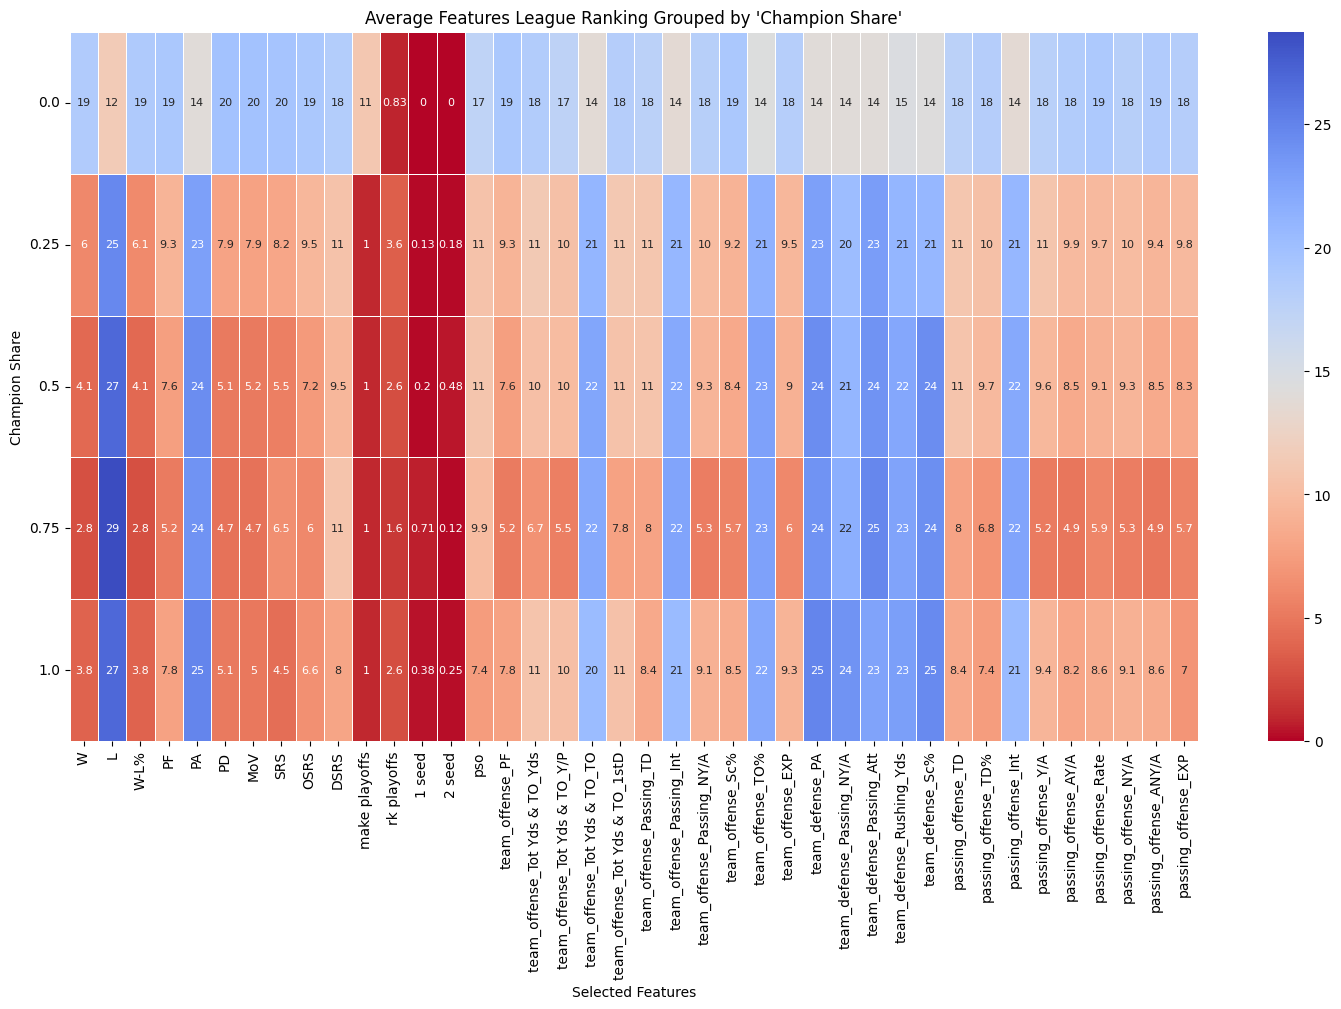

In [11]:
#finding data features that have a Pearson's Correlation Coefficient of at least medium strength with champion share
corr = data.corr().abs()
selected_features = corr.loc[corr['champion share']>.3].index

# Filter the DataFrame to include only selected features
corr_df = data[selected_features].groupby('champion share').mean()

# Plot the heatmap with adjusted font size
plt.rcParams['figure.figsize'] = (15, 10)
plt.title("Average Features League Ranking Grouped by 'Champion Share'")
sns.heatmap(data=corr_df, cmap='coolwarm_r', annot=True, linewidth=.5, annot_kws={"size": 8})

plt.xticks(rotation=90)  
plt.yticks(rotation=0)   

plt.tight_layout()  

plt.xlabel("Selected Features")
plt.ylabel("Champion Share")

plt.show()

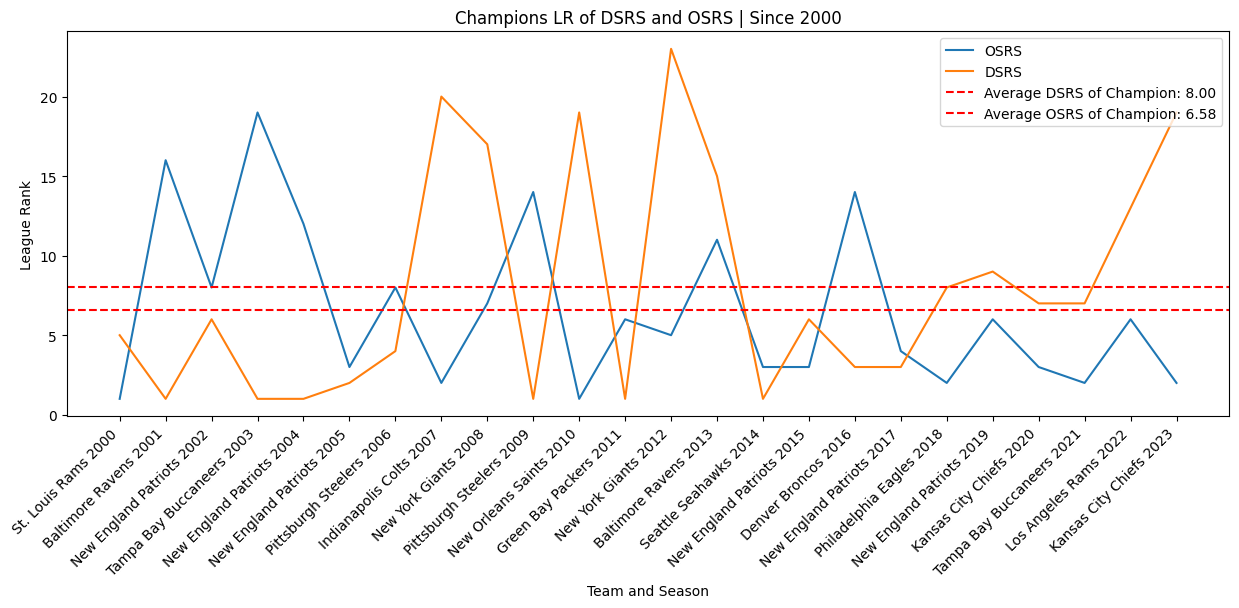

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Team' and 'Season' are columns in your DataFrame
champion_sea = df.loc[df['champion share'] == 1].copy()  # Create a copy to avoid SettingWithCopyWarning

# Sort the DataFrame by the 'Season' column
champion_sea.sort_values(by='Season', inplace=True)

# Convert 'Season' to string if it's not already
champion_sea['Season'] = champion_sea['Season'].astype(str)

plt.figure(figsize=(15, 5))
plt.title("Champions LR of DSRS and OSRS | Since 2000")
sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['OSRS'], label="OSRS")
sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['DSRS'], label="DSRS")

#Calculate average DSRS
average_dsrs = champion_sea['DSRS'].mean()
average_osrs = champion_sea['OSRS'].mean()

# Add a horizontal line for the average DSRS
plt.axhline(y=average_dsrs, color='r', linestyle='--', label=f'Average DSRS of Champion: {average_dsrs:.2f}')
plt.axhline(y=average_osrs, color='r', linestyle='--', label=f'Average OSRS of Champion: {average_osrs:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('League Rank')

# Set ticks for all team-season combinations
plt.xticks(rotation=45, ha='right')
plt.legend()  # Add legend to show labels
plt.show()


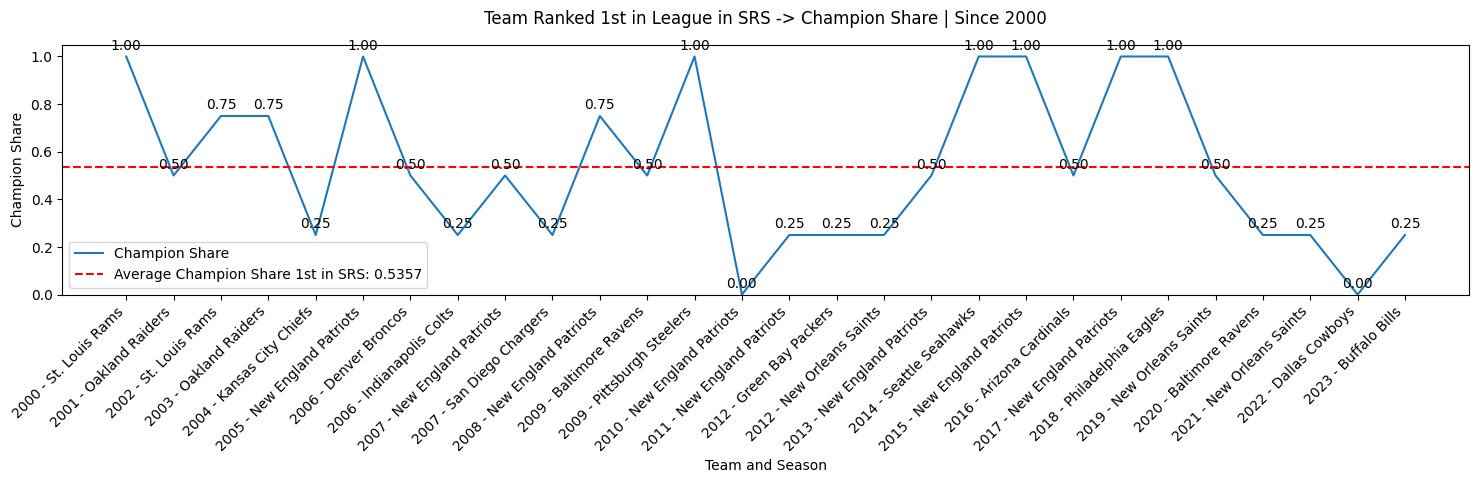

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame, df
# Assuming 'Team' column is present in the DataFrame

# Create DataFrame only selecting teams ranked 1st in the league in SRS since 2000
first_in_league_SRS = df.loc[df['SRS'] == 1].copy()

# Sort the DataFrame by the 'Season' column
first_in_league_SRS .sort_values(by='Season', inplace=True)

# Plotting
plt.figure(figsize=(15, 5))
plt.title("Team Ranked 1st in League in SRS -> Champion Share | Since 2000")

# Adjust the title position
plt.title("Team Ranked 1st in League in SRS -> Champion Share | Since 2000", y=1.05)

# Convert 'Season' column to string before concatenating using .loc
first_in_league_SRS.loc[:, 'Season'] = first_in_league_SRS['Season'].astype(str)

# Line plot for champion share without confidence interval
sns.lineplot(x=first_in_league_SRS['Season'] + " - " + first_in_league_SRS['Team'],
             y=first_in_league_SRS['champion share'],
             label="Champion Share", errorbar=None)

# Display team and season on x-axis with every season
plt.xticks(rotation=45, ha="right")

# Annotate each point with the champion share value
for i, row in first_in_league_SRS.iterrows():
    plt.annotate(f"{row['champion share']:.2f}", (row['Season'] + " - " + row['Team'], row['champion share']),
                 textcoords="offset points", xytext=(0, 5), ha='center')

# Calculate and display the average champion share
average_champion_share = first_in_league_SRS['champion share'].mean()
plt.axhline(y=average_champion_share, color='r', linestyle='--', label=f'Average Champion Share 1st in SRS: {average_champion_share:.4f}')

# Set labels and legend
plt.xlabel("Team and Season")
plt.ylabel("Champion Share")

# Set y-axis lower limit to 0
plt.ylim(bottom=0)

plt.legend()

plt.tight_layout()
plt.show()


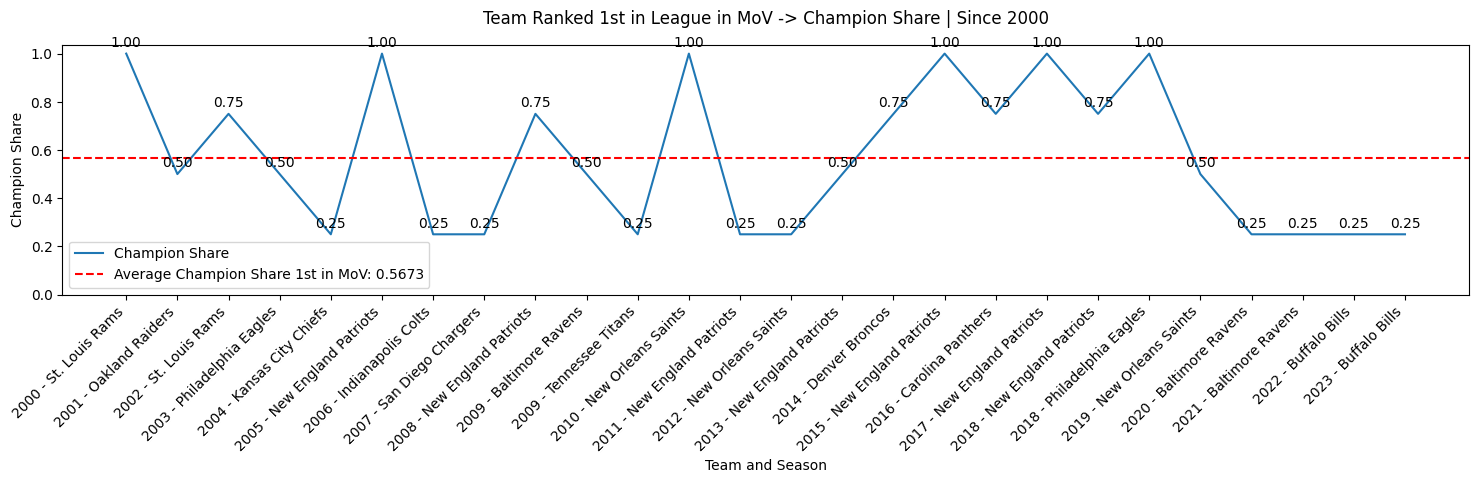

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame, df
# Assuming 'Team' column is present in the DataFrame

# Create DataFrame only selecting teams ranked 1st in the league in SRS since 2000
first_in_league_MoV = df.loc[df['MoV'] == 1].copy()

# Sort the DataFrame by the 'Season' column
first_in_league_MoV.sort_values(by='Season', inplace=True)

# Plotting
plt.figure(figsize=(15, 5))
plt.title("Team Ranked 1st in League in MoV -> Champion Share | Since 2000")

# Adjust the title position
plt.title("Team Ranked 1st in League in MoV -> Champion Share | Since 2000", y=1.05)

# Convert 'Season' column to string before concatenating using .loc
first_in_league_MoV.loc[:, 'Season'] = first_in_league_MoV['Season'].astype(str)

# Line plot for champion share without confidence interval
sns.lineplot(x=first_in_league_MoV['Season'] + " - " + first_in_league_MoV['Team'],
             y=first_in_league_MoV['champion share'],
             label="Champion Share", errorbar=None)

# Display team and season on x-axis with every season
plt.xticks(rotation=45, ha="right")

# Annotate each point with the champion share value
for i, row in first_in_league_MoV.iterrows():
    plt.annotate(f"{row['champion share']:.2f}", (row['Season'] + " - " + row['Team'], row['champion share']),
                 textcoords="offset points", xytext=(0, 5), ha='center')

# Calculate and display the average champion share
average_champion_share = first_in_league_MoV['champion share'].mean()
plt.axhline(y=average_champion_share, color='r', linestyle='--', label=f'Average Champion Share 1st in MoV: {average_champion_share:.4f}')

# Set labels and legend
plt.xlabel("Team and Season")
plt.ylabel("Champion Share")

# Set y-axis lower limit to 0
plt.ylim(bottom=0)

plt.legend()

plt.tight_layout()
plt.show()


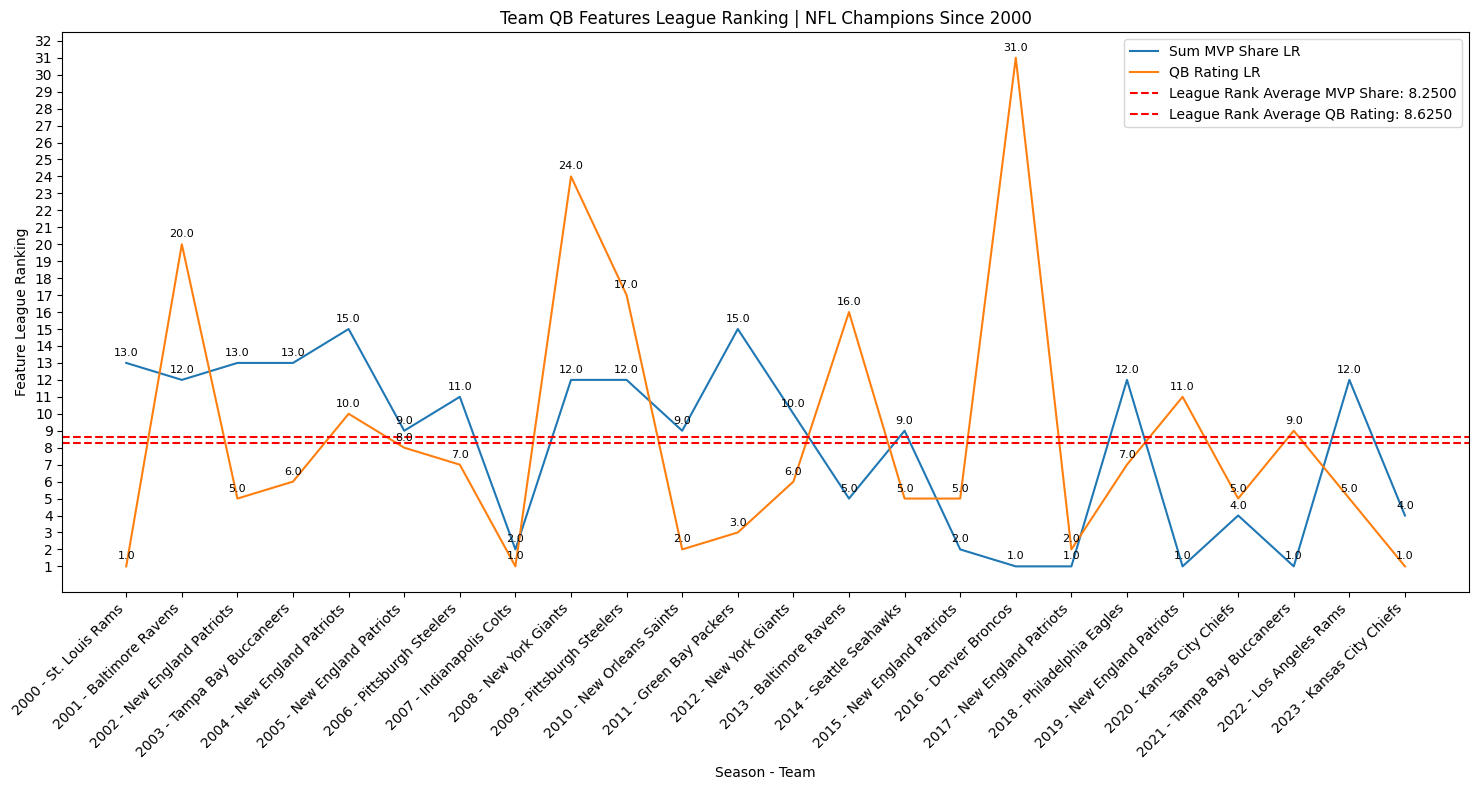

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame, df
# Assuming 'Team' column is present in the DataFrame

# Create a DataFrame to show the amount MVP share every NFL champion has had since 2000
champion = df.loc[df['champion share'] == 1.00].copy()

# Sort the DataFrame by the 'Season' column
champion.sort_values(by='Season', inplace=True)

# Set the figure size with an increased width
plt.figure(figsize=(15, 8))

# Use .loc to avoid the SettingWithCopyWarning
champion.loc[:, 'Season_Team'] = champion['Season'].astype(str) + " - " + champion['Team']

# Line plot for champion share without confidence interval
sns.lineplot(x=champion['Season_Team'], y=champion['sum mvp share'], label="Sum MVP Share LR", errorbar=None)
sns.lineplot(x=champion['Season_Team'], y=champion['passing_offense_Rate'], label="QB Rating LR", errorbar=None)

# Display x-axis ticks for every season and team
plt.xticks(rotation=45, ha="right")

# Specify y-axis ticks for league ranks from 1 to 32
plt.yticks(range(1, 33))

# Calculate and display the average league ranking in MVP share of the champion
average_mvp_ranking = champion['sum mvp share'].mean()
plt.axhline(y=average_mvp_ranking, color='r', linestyle='--', label=f'League Rank Average MVP Share: {average_mvp_ranking:.4f}')

average_mvp_ranking = champion['passing_offense_Rate'].mean()
plt.axhline(y=average_mvp_ranking, color='r', linestyle='--', label=f'League Rank Average QB Rating: {average_mvp_ranking:.4f}')

# Annotate the line plot with league ranks for each season and team
for season_team, rank in zip(champion['Season_Team'], champion['sum mvp share']):
    plt.annotate(f'{rank}', (season_team, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
    
for season_team, rank in zip(champion['Season_Team'], champion['passing_offense_Rate']):
    plt.annotate(f'{rank}', (season_team, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

# Set labels and legend
plt.title("Team QB Features League Ranking | NFL Champions Since 2000")
plt.xlabel("Season - Team")
plt.ylabel("Feature League Ranking")
plt.legend()

plt.tight_layout()
plt.show()


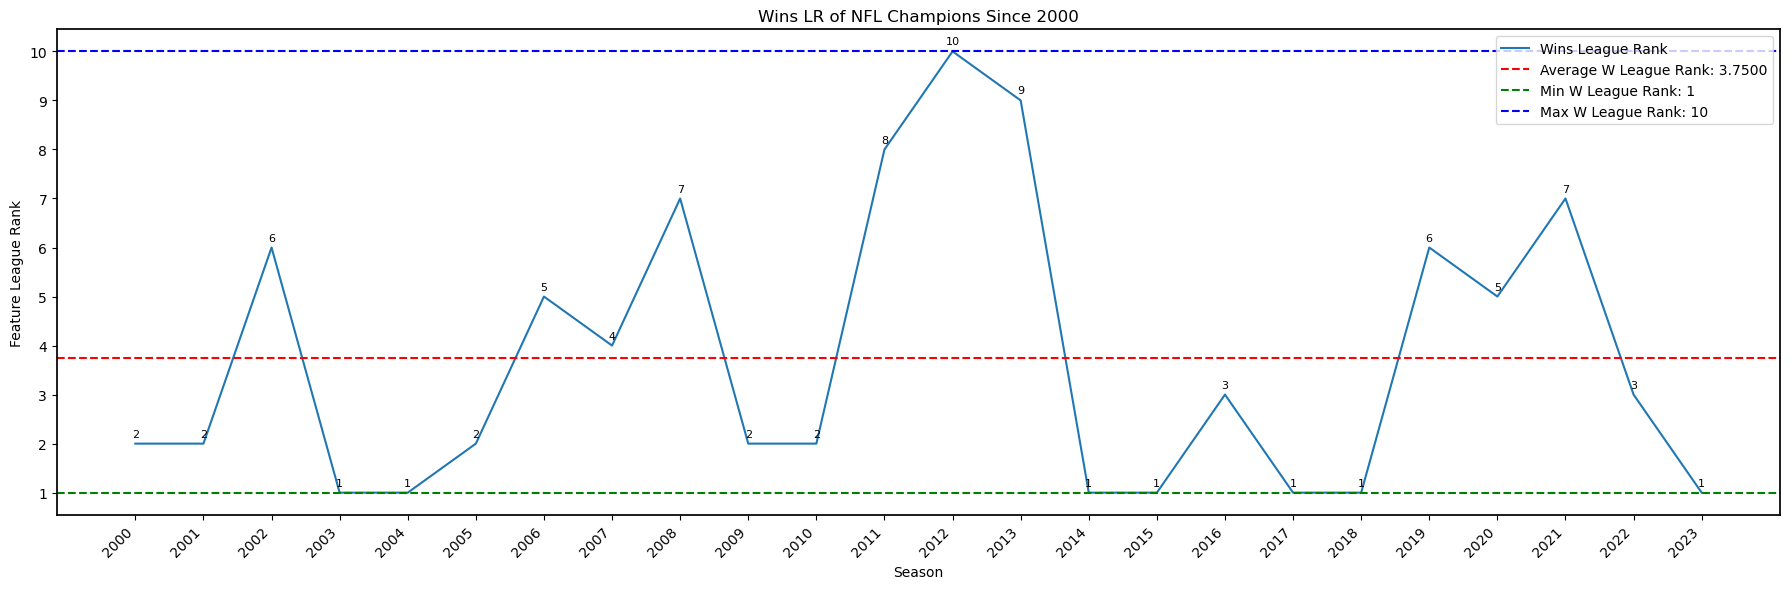

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to show the amount MVP share every NFL champion has had since 2000
champion = df.loc[df['champion share'] == 1.00]

# Set the figure size with an increased width
plt.figure(figsize=(18, 6))

# Line plot for champion share with confidence interval
sns.lineplot(x=champion['Season'], y=champion['W'], label="Wins League Rank", err_style="band")

# Display x-axis ticks for every season
plt.xticks(champion['Season'].unique(), rotation=45, ha="right")

# Specify y-axis ticks for league ranks from 1 to 30
plt.yticks(range(1, 11))

# Calculate and display the average, minimum, and maximum league ranking in Wins of the champion
average_champion_wins_ranking = champion['W'].mean()
min_champion_wins_ranking = champion['W'].min()
max_champion_wins_ranking = champion['W'].max()

plt.axhline(y=average_champion_wins_ranking, color='r', linestyle='--', label=f'Average W League Rank: {average_champion_wins_ranking:.4f}')
plt.axhline(y=min_champion_wins_ranking, color='g', linestyle='--', label=f'Min W League Rank: {min_champion_wins_ranking}')
plt.axhline(y=max_champion_wins_ranking, color='b', linestyle='--', label=f'Max W League Rank: {max_champion_wins_ranking}')

# Annotate the line plot with league ranks for each season
for season, rank in zip(champion['Season'], champion['W']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

# Set labels and legend
plt.title("Wins LR of NFL Champions Since 2000")
plt.xlabel("Season")
plt.ylabel("Feature League Rank")
plt.legend()

plt.tight_layout()
plt.show()


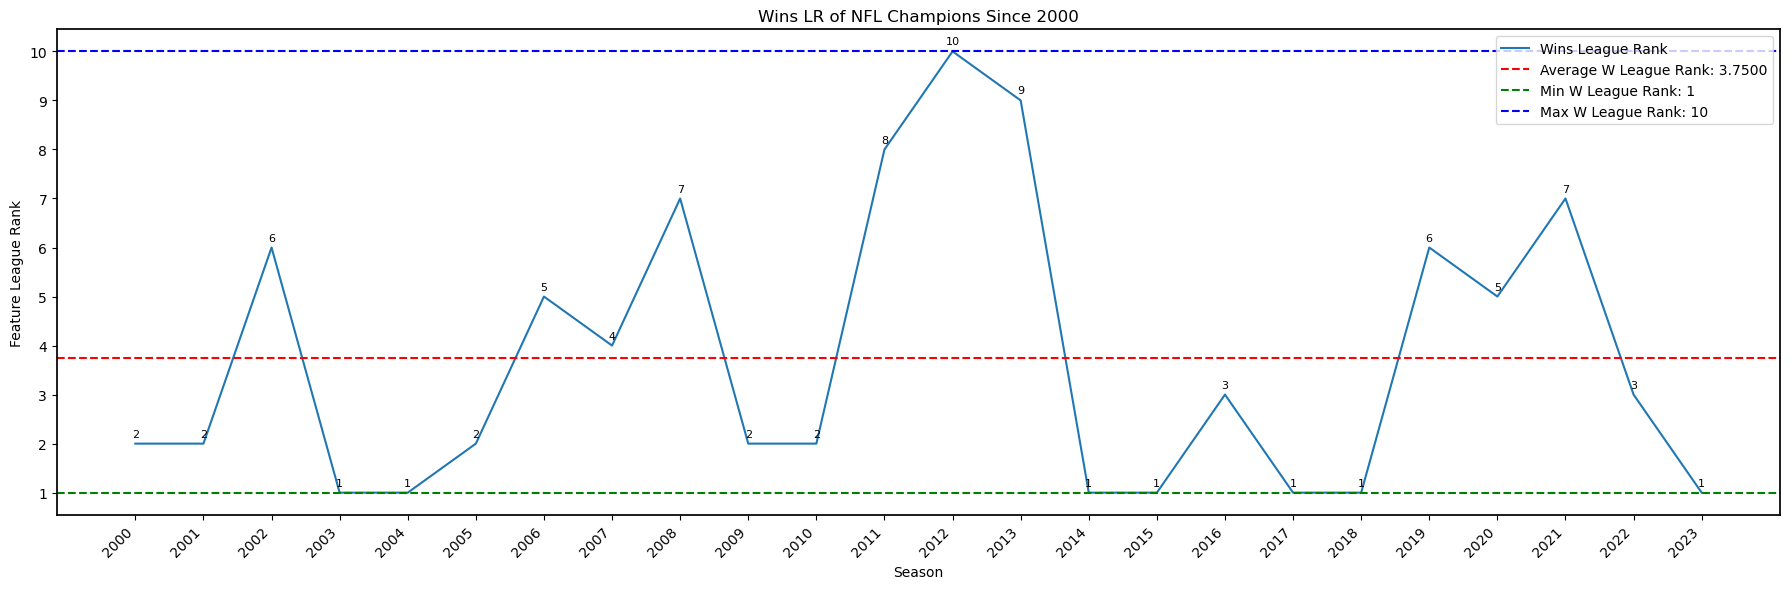

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to show the amount MVP share every NFL champion has had since 2000
champion = df.loc[df['champion share'] == 1.00]

# Set the figure size with an increased width
plt.figure(figsize=(18, 6))

# Line plot for champion share with confidence interval
sns.lineplot(x=champion['Season'], y=champion['W'], label="Wins League Rank", err_style="band")

# Display x-axis ticks for every season
plt.xticks(champion['Season'].unique(), rotation=45, ha="right")

# Specify y-axis ticks for league ranks from 1 to 30
plt.yticks(range(1, 11))

# Calculate and display the average, minimum, and maximum league ranking in Wins of the champion
average_champion_wins_ranking = champion['W'].mean()
min_champion_wins_ranking = champion['W'].min()
max_champion_wins_ranking = champion['W'].max()

plt.axhline(y=average_champion_wins_ranking, color='r', linestyle='--', label=f'Average W League Rank: {average_champion_wins_ranking:.4f}')
plt.axhline(y=min_champion_wins_ranking, color='g', linestyle='--', label=f'Min W League Rank: {min_champion_wins_ranking}')
plt.axhline(y=max_champion_wins_ranking, color='b', linestyle='--', label=f'Max W League Rank: {max_champion_wins_ranking}')

# Annotate the line plot with league ranks for each season
for season, rank in zip(champion['Season'], champion['W']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

# Set labels and legend
plt.title("Wins LR of NFL Champions Since 2000")
plt.xlabel("Season")
plt.ylabel("Feature League Rank")
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
#Champions | Summary Stats W
champion = df.loc[df['champion share'] == 1.00]

champion_wins_rank_summary = champion['W'].describe()

print("Summary Statistics for Champions' League Rank of Wins:")
print(champion_wins_rank_summary)


#Champions | Summary Stats SRS
champion = df.loc[df['champion share'] == 1.00]

champion_srs_rank_summary = champion['SRS'].describe()

print("Summary Statistics for Champions' League Rank of SRS:")
print(champion_srs_rank_summary)

Summary Statistics for Champions' League Rank of Wins:
count    24.000000
mean      3.750000
std       2.862805
min       1.000000
25%       1.000000
50%       2.500000
75%       6.000000
max      10.000000
Name: W, dtype: float64
Summary Statistics for Champions' League Rank of SRS:
count    24.000000
mean      4.458333
std       3.647264
min       1.000000
25%       1.000000
50%       3.500000
75%       6.250000
max      12.000000
Name: SRS, dtype: float64


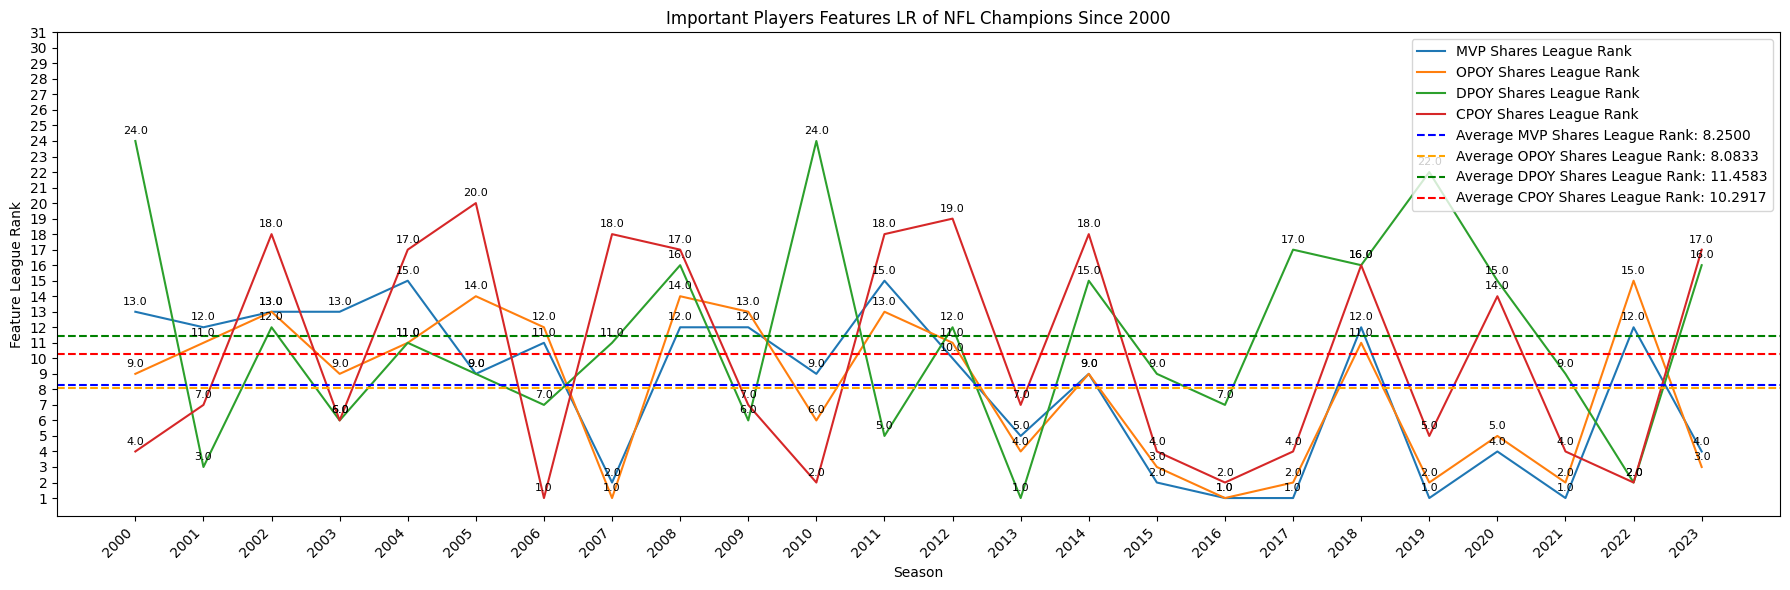

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to show the amount MVP share every NFL champion has had since 2000
champion = df.loc[df['champion share'] == 1.00]

# Set the figure size with an increased width
plt.figure(figsize=(18, 6))

# Line plot for champion share with confidence interval
sns.lineplot(x=champion['Season'], y=champion['sum mvp share'], label="MVP Shares League Rank", err_style="band")
sns.lineplot(x=champion['Season'], y=champion['sum opoy share'], label="OPOY Shares League Rank", err_style="band")
sns.lineplot(x=champion['Season'], y=champion['sum dpoy share'], label="DPOY Shares League Rank", err_style="band")
sns.lineplot(x=champion['Season'], y=champion['sum cpoy share'], label="CPOY Shares League Rank", err_style="band")


# Display x-axis ticks for every season
plt.xticks(champion['Season'].unique(), rotation=45, ha="right")

# Specify y-axis ticks for league ranks from 1 to 30
plt.yticks(range(1, 32))

# Calculate and display the average, minimum, and maximum league ranking in Wins of the champion
average_champion_ms_ranking = champion['sum mvp share'].mean()
average_champion_os_ranking = champion['sum opoy share'].mean()
average_champion_ds_ranking = champion['sum dpoy share'].mean()
average_champion_cs_ranking = champion['sum cpoy share'].mean()

plt.axhline(y=average_champion_ms_ranking, color='blue', linestyle='--', label=f'Average MVP Shares League Rank: {average_champion_ms_ranking:.4f}')
plt.axhline(y=average_champion_os_ranking, color='orange', linestyle='--', label=f'Average OPOY Shares League Rank: {average_champion_os_ranking:.4f}')
plt.axhline(y=average_champion_ds_ranking, color='green', linestyle='--', label=f'Average DPOY Shares League Rank: {average_champion_ds_ranking:.4f}')
plt.axhline(y=average_champion_cs_ranking, color='red', linestyle='--', label=f'Average CPOY Shares League Rank: {average_champion_cs_ranking:.4f}')

# Annotate the line plot with league ranks for each season
for season, rank in zip(champion['Season'], champion['sum mvp share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
for season, rank in zip(champion['Season'], champion['sum opoy share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
for season, rank in zip(champion['Season'], champion['sum dpoy share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
for season, rank in zip(champion['Season'], champion['sum cpoy share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

# Set labels and legend
plt.title("Important Players Features LR of NFL Champions Since 2000")
plt.xlabel("Season")
plt.ylabel("Feature League Rank")
plt.legend()

plt.tight_layout()
plt.show()


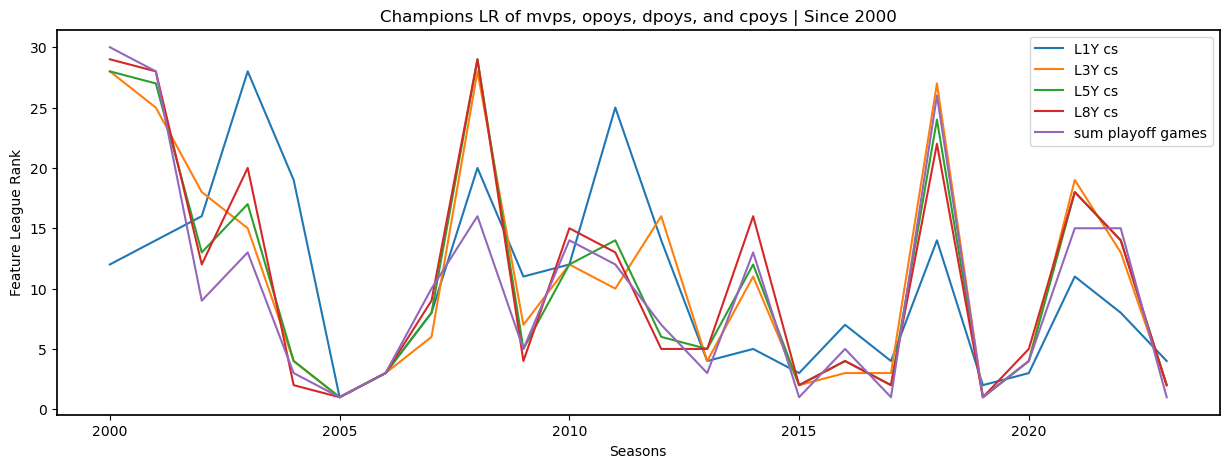

In [37]:
#what playoff stats best fit champions

champion_sea = df.loc[df['champion share']==1]

plt.figure(figsize=(15,5))
plt.title("Champions LR of mvps, opoys, dpoys, and cpoys | Since 2000")
sns.lineplot(x=champion_sea.Season, y=champion_sea['L1Y cs'],label="L1Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['L3Y cs'],label="L3Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['L5Y cs'],label="L5Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['L8Y cs'],label="L8Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum playoff games'],label="sum playoff games")
plt.xlabel('Seasons')
plt.ylabel('Feature League Rank')
plt.show()

Pearson Correlation Coefficient: 0.9246


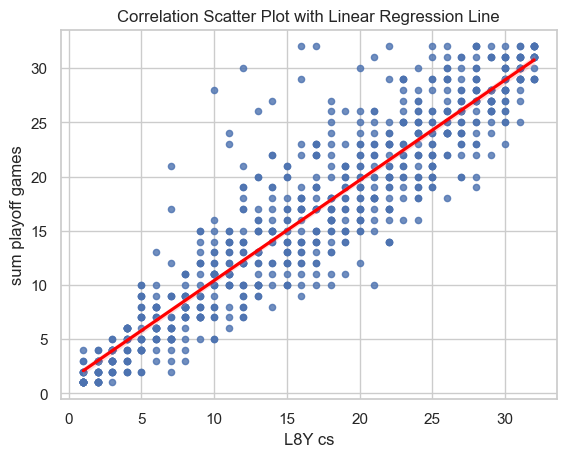

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming 'data' is your DataFrame
sns.set(style="whitegrid")  # Optional: Set the style of the plot

# Create a scatter plot with a linear regression line
sns.regplot(x=data['sum playoff games'], y=data['L8Y cs'], scatter_kws={"s": 20}, line_kws={"color": "red"})

# Set labels for the axes
plt.xlabel("L8Y cs")
plt.ylabel("sum playoff games")

# Set the title for the plot
plt.title("Correlation Scatter Plot with Linear Regression Line")

# Calculate the Pearson correlation coefficient
correlation_coefficient, _ = pearsonr(data['sum playoff games'], data['L8Y cs'])
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")

plt.show()


Pearson Correlation Coefficient: 0.2318


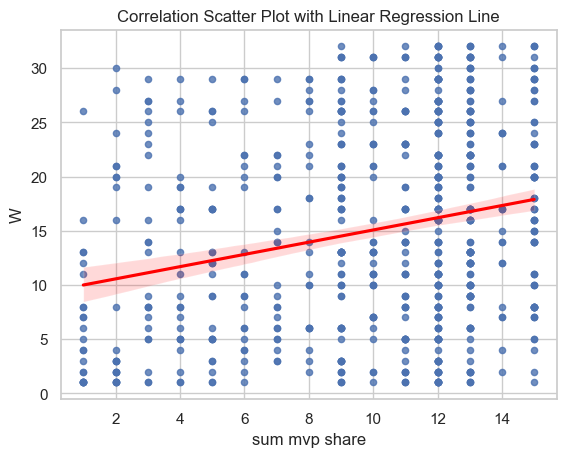

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming 'data' is your DataFrame
sns.set(style="whitegrid")  # Optional: Set the style of the plot

# Create a scatter plot with a linear regression line
sns.regplot(x=data['sum mvp share'], y=data['W'], scatter_kws={"s": 20}, line_kws={"color": "red"})

# Set labels for the axes
plt.xlabel("sum mvp share")
plt.ylabel("W")

# Set the title for the plot
plt.title("Correlation Scatter Plot with Linear Regression Line")

# Calculate the Pearson correlation coefficient
correlation_coefficient, _ = pearsonr(data['sum mvp share'], data['W'])
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")

plt.show()


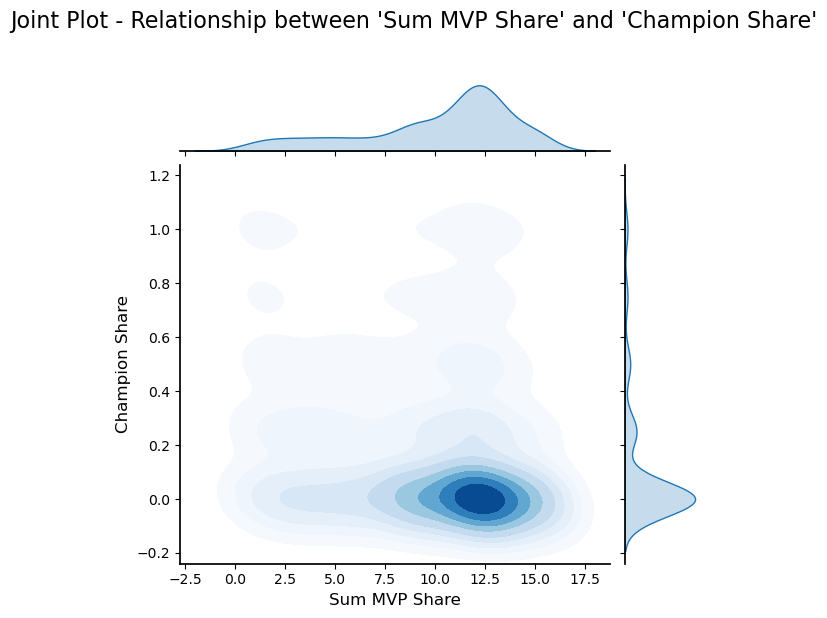

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
joint_plot = sns.jointplot(x=data['sum mvp share'], y=data['champion share'], kind='kde', fill=True, cmap='Blues')

# Set labels for the axes
joint_plot.set_axis_labels("Sum MVP Share", "Champion Share", fontsize=12)

# Set the title for the joint plot
joint_plot.fig.suptitle("Joint Plot - Relationship between 'Sum MVP Share' and 'Champion Share'", y=1.02, fontsize=16)

# Adjust position of the title to bring it to the front
joint_plot.fig.subplots_adjust(top=0.9)

plt.show()

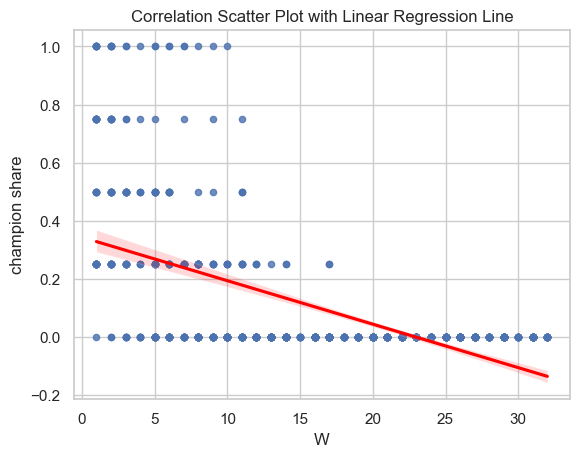

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
sns.set(style="whitegrid")  # Optional: Set the style of the plot

# Create a scatter plot with a linear regression line
sns.regplot(x=data['W'], y=data['champion share'], scatter_kws={"s": 20}, line_kws={"color": "red"})

# Set labels for the axes
plt.xlabel("W")
plt.ylabel("champion share")

# Set the title for the plot
plt.title("Correlation Scatter Plot with Linear Regression Line")

plt.show()


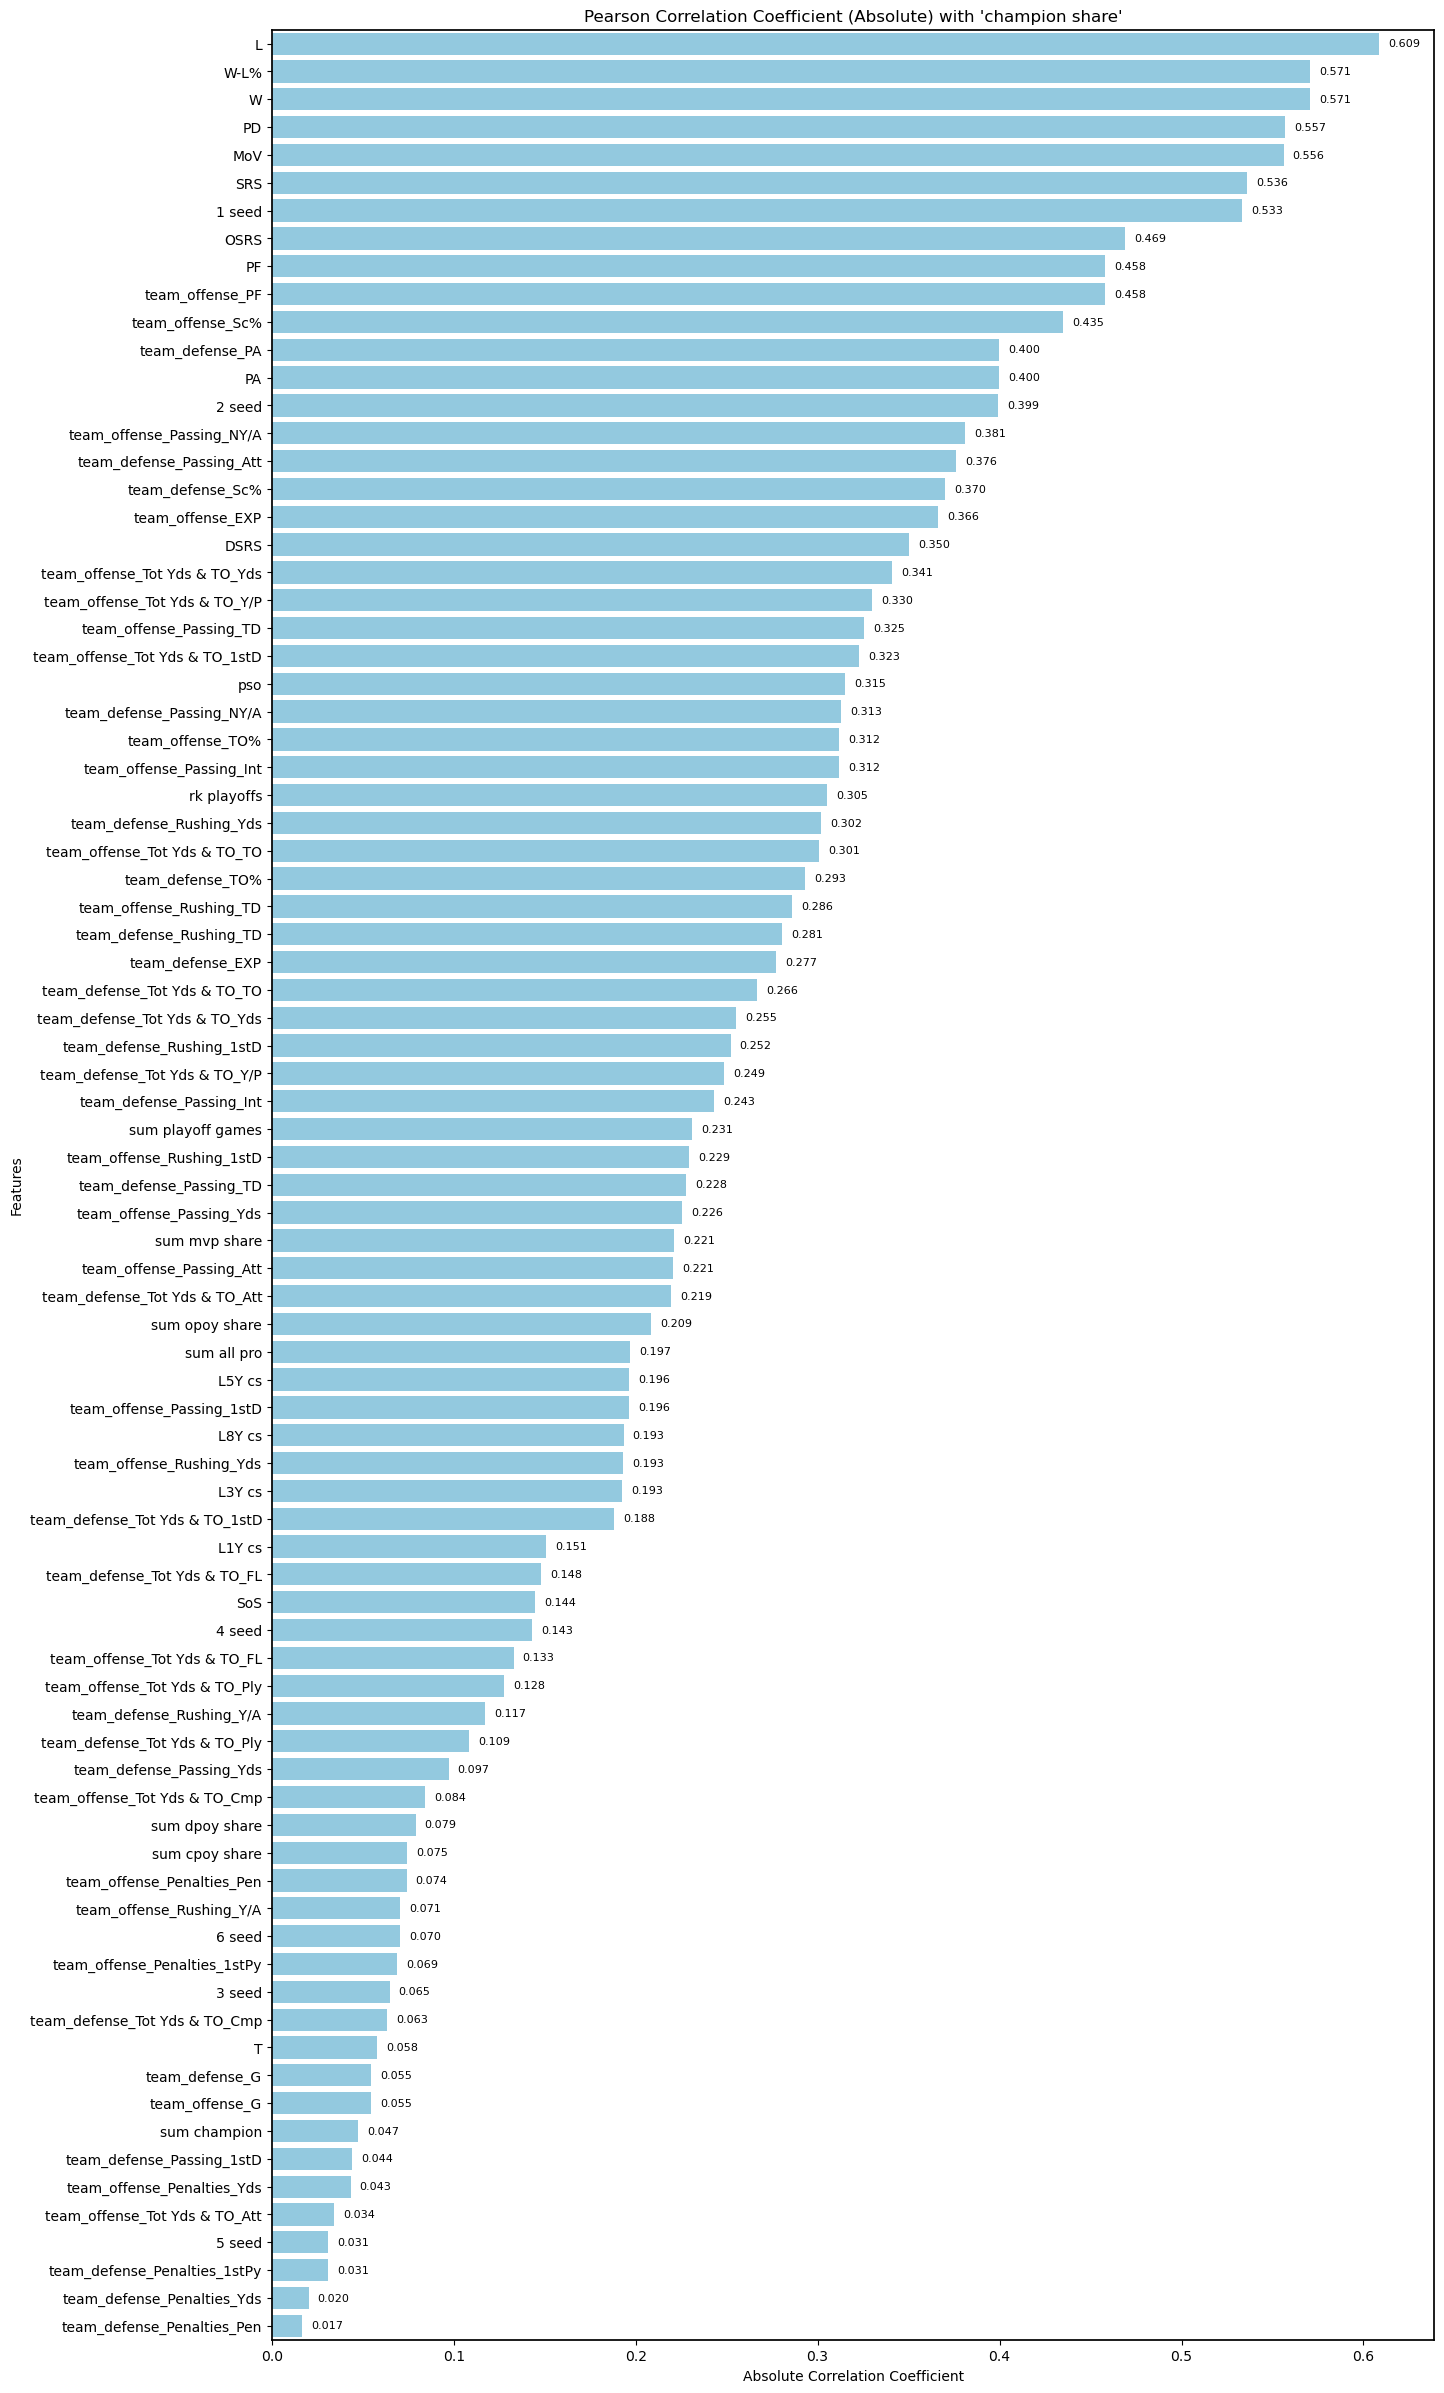

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting the relevant columns
data_columns = ['sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games',
                'sum champion', 'L1Y cs', 'L3Y cs', 'L5Y cs', 'L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS',
                'SRS', 'OSRS', 'DSRS', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed',
                'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply',
                'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD',
                'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int',
                'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD',
                'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy',
                'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP', 'team_defense_G', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply',
                'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD',
                'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 'team_defense_Passing_Int',
                'team_defense_Passing_NY/A', 'team_defense_Passing_1stD', 'team_defense_Passing_Att', 'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A',
                'team_defense_Rushing_1stD', 'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP']

# Create a DataFrame with the selected columns
selected_data = df[data_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Extract correlations with 'champion share'
correlation_with_champion = correlation_matrix['champion share'].drop('champion share')

# Sort by absolute correlation coefficient
sorted_correlation = correlation_with_champion.abs().sort_values(ascending=False)

# Plot the bar chart with features on the y-axis
plt.figure(figsize=(15, 30))
ax = sns.barplot(x=sorted_correlation.values, y=sorted_correlation.index, color='skyblue')

# Add text labels at the end of each bar
for i, value in enumerate(sorted_correlation):
    ax.text(value + 0.005, i, f'{value:.3f}', va='center', fontsize=8)

plt.title("Pearson Correlation Coefficient (Absolute) with 'champion share'")
plt.xlabel("Absolute Correlation Coefficient")
plt.ylabel("Features")
plt.show()


Column Averages:
W                     3.750000
SRS                   4.458333
rk playoffs           2.583333
OSRS                  6.583333
DSRS                  8.000000
sum mvp share         8.250000
team_offense_Sc%      8.541667
pso                   7.375000
sum playoff games     9.833333
sum all pro          10.083333
dtype: float64


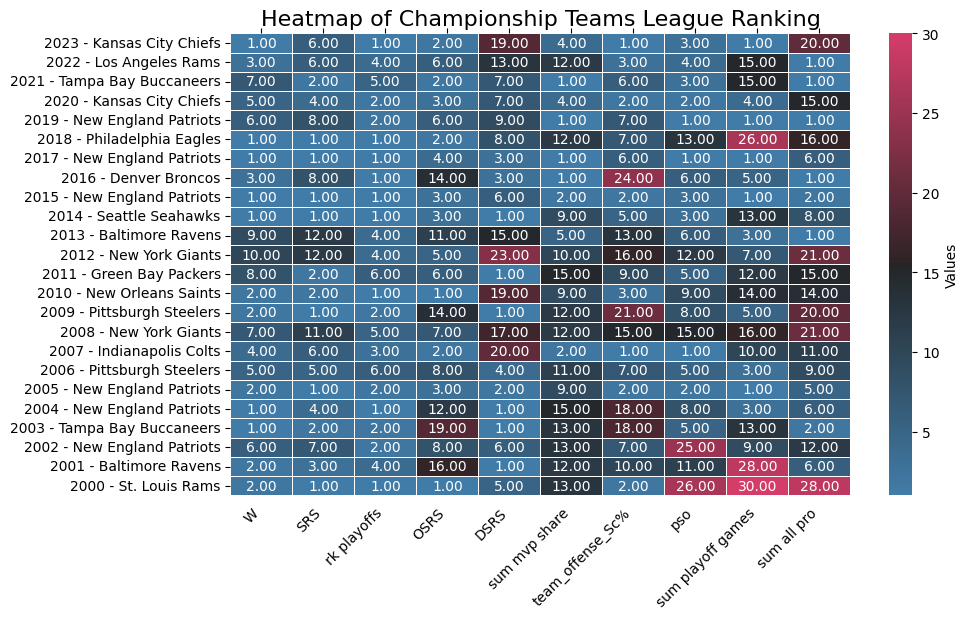

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom color palette with red, purple, and blue shades
custom_palette = sns.diverging_palette(240, 0, s=75, l=50, n=10, center="dark", as_cmap=True)

# Assuming champions_only is your filtered DataFrame
champions_only = df.loc[df['champion share'] == 1, ['Season', 'Team', 'W','SRS', 'rk playoffs', 'OSRS', 'DSRS', 'sum mvp share', 'team_offense_Sc%', 'pso', 'sum playoff games', 'sum all pro']]

# Selecting the relevant columns
heatmap_data = champions_only[['W','SRS', 'rk playoffs', 'OSRS', 'DSRS', 'sum mvp share', 'team_offense_Sc%', 'pso', 'sum playoff games', 'sum all pro']]

# Create a heatmap table with custom color palette
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=custom_palette, linewidths=.5, cbar_kws={'label': 'Values'})

# Set custom labels on the y-axis at the middle of the boxes
championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

# Set column (feature) headers at the top of the chart
column_headers = heatmap_data.columns.tolist()
plt.xticks(ticks=[i + 0.5 for i in range(len(column_headers))], labels=column_headers, rotation=45, ha="right")

# Move x-axis labels to the top
plt.tick_params(axis='x', which='both', bottom=False, top=True)

# Print the average for each column
column_averages = heatmap_data.mean()
print("Column Averages:")
print(column_averages)

# Customize the plot
plt.title('Heatmap of Championship Teams League Ranking', fontsize=16)
plt.show()
